In [1]:
import os
import logging
import numpy as np
import matplotlib.pyplot as plt
from random import random

from astropy.io import fits
from astropy.table import Table, vstack
import astropy.units as u


import sompy
import sklearn_som.som as sklearn_som
from sklearn.decomposition import PCA


def errJy_to_errABmag(flux_Jy, fluxerr_Jy):
    return -2.5 / (flux_Jy * np.log(10)) * fluxerr_Jy

def mag_snr(magerr):
    return 2.5 / (np.log(10) * magerr)

plt.rcParams.update({
    'font.family': 'serif',
    'font.size': 18,
    'axes.labelsize': 'large',
    'mathtext.fontset': 'stix'
})

logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)

## SOMPY test

In [3]:
#load in data produced in primary_targeting_region.ipynb
cut_data_file = '/data2/lsajkov/mpdg/data_products/GAMA/GAMA_primtarg_snr100_lms3_20jun2024.fits'

with fits.open(cut_data_file) as cat:
    GAMA_vect_data = Table(cat[1].data)

In [55]:
#select random subset of data
#initialize array of Falses, flip randomly until a desired fraction is reached
random_fraction = 0.25 #select random_fraction of data (e.g. 0.1 will select 10% of the data, randomly)

number_of_entries = len(GAMA_vect_data)
random_idx = [False] * number_of_entries

while sum(random_idx)/number_of_entries < random_fraction:
    i = int(random() * number_of_entries)
    random_idx[i] = True

random_idx_complement = [not entry for entry in random_idx]

if sum(random_idx) + sum(random_idx_complement) == number_of_entries:
    print(f'Selected {sum(random_idx)} out of {number_of_entries} entries ({int(100 * sum(random_idx)/number_of_entries)}%)')
else: raise(ValueError('Random array and its complement do not sum to total number of elements!'))

Selected 8465 out of 33857 entries (25%)


In [59]:
training_data = GAMA_vect_data[random_idx]

r_mag            = list(training_data['r_mag'])
r_mag_err        = list(training_data['r_mag_err'])
gr_color         = list(training_data['gr_color'])
gr_color_err     = list(training_data['gr_color_err'])
surf_bright      = list(training_data['surf_bright_r'])

log_stellar_mass = list(training_data['log_stellar_mass'])
redshift         = list(training_data['redshift'])

testing_data = GAMA_vect_data[random_idx_complement]

r_mag_test            = list(testing_data['r_mag'])
r_mag_err_test        = list(testing_data['r_mag_err'])
gr_color_test         = list(testing_data['gr_color'])
gr_color_err_test     = list(testing_data['gr_color_err'])
surf_bright_test      = list(testing_data['surf_bright_r'])

log_stellar_mass_test = list(testing_data['log_stellar_mass'])
redshift_test         = list(testing_data['redshift'])

In [76]:
SOMready_training_data = list(zip(r_mag, gr_color, surf_bright, log_stellar_mass))
SOMready_training_data = np.array(SOMready_training_data)

SOMready_testing_data = list(zip(r_mag_test, gr_color_test, surf_bright_test))
SOMready_testing_data = np.array(SOMready_testing_data)

In [61]:
mapsize = [16, 16]

SOM = sompy.SOMFactory.build(SOMready_training_data,
                             mapsize = mapsize,
                             component_names = ['r_mag', 'gr_color', 'surf_bright', 'log_stellar_mass'])

In [96]:
SOM.train(n_job = 3, train_len_factor = 30, verbose = 'info')

 Training...
 pca_linear_initialization took: 0.014000 seconds
 Rough training...
 radius_ini: 2.000000 , radius_final: 1.000000, trainlen: 30

 epoch: 1 ---> elapsed time:  0.063000, quantization error: 0.786993

 epoch: 2 ---> elapsed time:  0.075000, quantization error: 0.745075

 epoch: 3 ---> elapsed time:  0.065000, quantization error: 0.728901

 epoch: 4 ---> elapsed time:  0.060000, quantization error: 0.719307

 epoch: 5 ---> elapsed time:  0.061000, quantization error: 0.708716

 epoch: 6 ---> elapsed time:  0.070000, quantization error: 0.698834

 epoch: 7 ---> elapsed time:  0.075000, quantization error: 0.689707

 epoch: 8 ---> elapsed time:  0.064000, quantization error: 0.681115

 epoch: 9 ---> elapsed time:  0.066000, quantization error: 0.673549

 epoch: 10 ---> elapsed time:  0.073000, quantization error: 0.666331

 epoch: 11 ---> elapsed time:  0.060000, quantization error: 0.659889

 epoch: 12 ---> elapsed time:  0.076000, quantization error: 0.653800

 epoch: 13 --

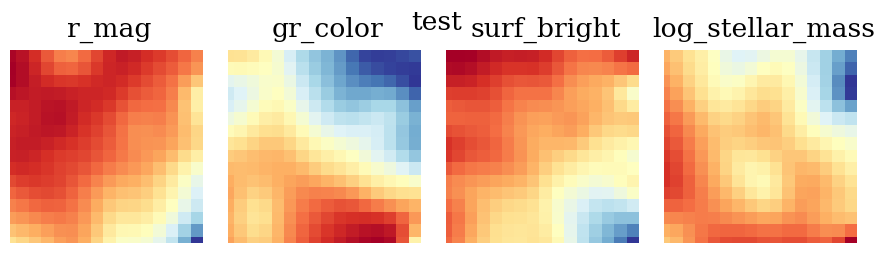

In [97]:
SOM_plot = sompy.mapview.View2DPacked(16, 16, 'test', text_size = 16)
SOM_plot.show(SOM)

In [98]:
predicted_logmstar = SOM.predict(SOMready_testing_data)

<>:7: SyntaxWarning: invalid escape sequence '\o'
<>:8: SyntaxWarning: invalid escape sequence '\o'
<>:7: SyntaxWarning: invalid escape sequence '\o'
<>:8: SyntaxWarning: invalid escape sequence '\o'
/var/tmp/lsajkov/ipykernel_3805029/2913909293.py:7: SyntaxWarning: invalid escape sequence '\o'
  ax.set_xlabel('GAMA log$(M_*/M_{\odot})$')
/var/tmp/lsajkov/ipykernel_3805029/2913909293.py:8: SyntaxWarning: invalid escape sequence '\o'
  ax.set_ylabel('SOM log$(M_*/M_{\odot})$')


Text(0, 0.5, 'SOM log$(M_*/M_{\\odot})$')

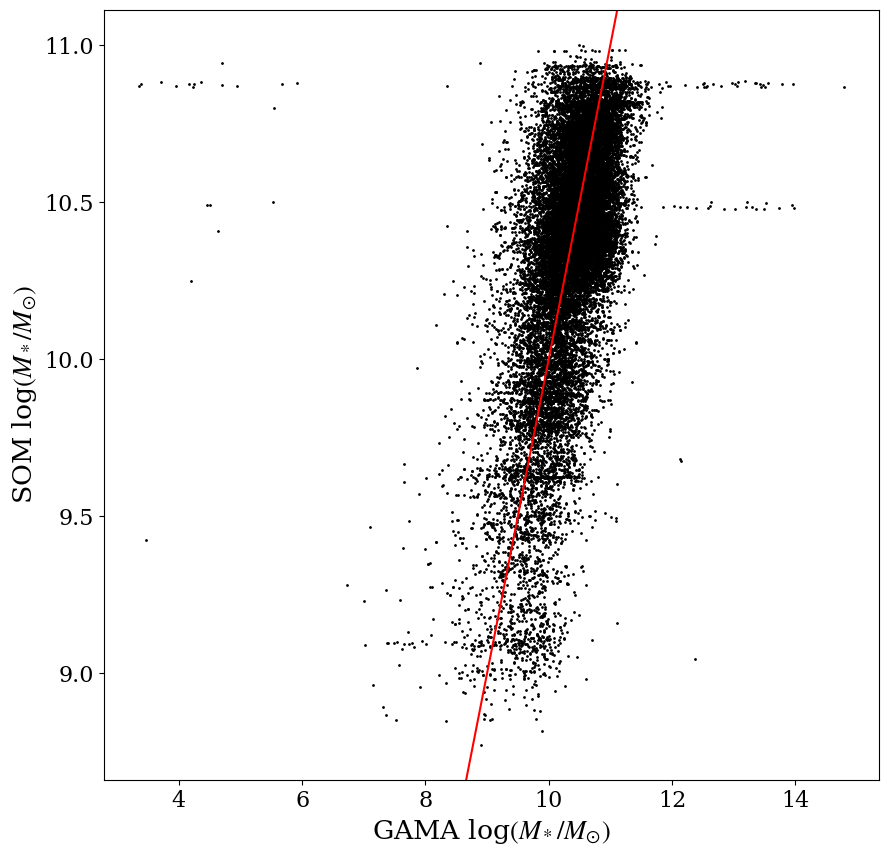

In [104]:
fig = plt.figure(figsize = (10, 10))
ax = fig.add_subplot()

ax.scatter(log_stellar_mass_test, predicted_logmstar, color = 'black', s = 1)
ax.axline([10, 10], slope = 1, color = 'red')

ax.set_xlabel('GAMA log$(M_*/M_{\odot})$')
ax.set_ylabel('SOM log$(M_*/M_{\odot})$')

# ax.set_ylim(9, 11.3)
# ax.set_xlim(9, 11.3)

## Try with scikit (sklearn-som)

In [61]:
#load in data produced in primary_targeting_region.ipynb
cut_data_file = '/data2/lsajkov/mpdg/data_products/GAMA/GAMA_primtarg_snr80_lms6_12_24jun2024.fits'

with fits.open(cut_data_file) as cat:
    GAMA_vect_data = Table(cat[1].data)

In [64]:
#select random subset of data
#initialize array of Falses, flip randomly until a desired fraction is reached
random_fraction = 0.1 #select random_fraction of data (e.g. 0.1 will select 10% of the data, randomly)

number_of_entries = len(GAMA_vect_data)
random_idx = [False] * number_of_entries

while sum(random_idx)/number_of_entries < random_fraction:
    i = int(random() * number_of_entries)
    random_idx[i] = True

random_idx_complement = [not entry for entry in random_idx]

if sum(random_idx) + sum(random_idx_complement) == number_of_entries:
    print(f'Selected {sum(random_idx)} out of {number_of_entries} entries ({int(100 * sum(random_idx)/number_of_entries)}%)')
else: raise(ValueError('Random array and its complement do not sum to total number of elements!'))

Selected 9338 out of 93374 entries (10%)


In [138]:
training_data = GAMA_vect_data[random_idx]

r_mag            = np.array(training_data['r_mag'])
r_mag_err        = np.array(training_data['r_mag_err'])
gr_color         = np.array(training_data['gr_color'])
gr_color_err     = np.array(training_data['gr_color_err'])
surf_bright      = np.array(training_data['surf_bright_r'])

log_stellar_mass = np.array(training_data['log_stellar_mass'])
redshift         = np.array(training_data['redshift'])

testing_data = GAMA_vect_data[random_idx_complement]

r_mag_test            = np.array(testing_data['r_mag'])
r_mag_err_test        = np.array(testing_data['r_mag_err'])
gr_color_test         = np.array(testing_data['gr_color'])
gr_color_err_test     = np.array(testing_data['gr_color_err'])
surf_bright_test      = np.array(testing_data['surf_bright_r'])

log_stellar_mass_test = np.array(testing_data['log_stellar_mass'])
redshift_test         = np.array(testing_data['redshift'])

In [174]:
training_data     = GAMA_vect_data[random_idx]['r_mag', 'gr_color', 'surf_bright_r',
                                           'log_stellar_mass', 'redshift']

testing_data_data = GAMA_vect_data[random_idx_complement]['r_mag', 'gr_color', 'surf_bright_r',
                                           'log_stellar_mass', 'redshift']


In [286]:
normalization_params_train = {}
normalization_params_test  = {}

for variable in training_data.keys():
    normalization_params_train[variable] = {}
    normalization_params_train[variable]['mean'] = np.mean(training_data[variable])
    normalization_params_train[variable]['std']  = np.std(training_data[variable])

    normalization_params_test[variable] = {}
    normalization_params_test[variable]['mean'] = np.mean(testing_data[variable])
    normalization_params_test[variable]['std']  = np.std(testing_data[variable])

In [294]:
training_data_norm = training_data.copy()
testing_data_norm  = testing_data.copy()

print('Param\tMean\tVar')
print(f'{22 * "-"}')
for variable in training_data.keys():
    
    training_data_norm[variable] -= normalization_params_train[variable]['mean']
    training_data_norm[variable] /= normalization_params_train[variable]['std']

    testing_data_norm[variable] -= normalization_params_test[variable]['mean']
    testing_data_norm[variable] /= normalization_params_test[variable]['std']

    print(f'{variable[:7]}\t{np.mean(training_data[variable]):.3f}\t{np.var(training_data[variable]):.3f}')
    print(f'normed \t{np.mean(training_data_norm[variable]):.3f}\t{np.var(training_data_norm[variable]):.3f}')
    print(f'test\t{np.mean(testing_data[variable]):.3f}\t{np.var(testing_data[variable]):.3f}')
    print(f'normed \t{np.mean(testing_data_norm[variable]):.3f}\t{np.var(testing_data_norm[variable]):.3f}')
    print(f'{22 * "-"}')

training_data_norm = list(zip(training_data_norm['r_mag'],
                              training_data_norm['gr_color'],
                              training_data_norm['surf_bright_r'],
                              training_data_norm['log_stellar_mass'],
                              training_data_norm['redshift']))
training_data_norm = np.array(training_data_norm)

testing_data_norm = list(zip(testing_data_norm['r_mag'],
                             testing_data_norm['gr_color'],
                             testing_data_norm['surf_bright_r']))#,
                            #  testing_data_norm['log_stellar_mass'],
                            #  testing_data_norm['redshift']))
testing_data_norm = np.array(testing_data_norm)

Param	Mean	Var
----------------------
r_mag	17.725	1.204
normed 	0.000	1.000
test	17.722	1.211
normed 	0.000	1.000
----------------------
gr_colo	0.523	0.016
normed 	0.000	1.000
test	0.523	0.016
normed 	0.000	1.000
----------------------
surf_br	21.813	0.473
normed 	0.000	1.000
test	21.807	0.476
normed 	-0.000	1.000
----------------------
log_ste	10.345	0.293
normed 	-0.000	1.000
test	10.351	0.282
normed 	-0.000	1.000
----------------------
redshif	0.155	0.007
normed 	-0.000	1.000
test	0.155	0.007
normed 	-0.000	1.000
----------------------


In [288]:
SOM = sklearn_som.SOM(m = 16, n = 16,
                      dim = 5, lr = 1,
                      max_iter = 3e5)

In [289]:
SOM.fit(training_data_norm, )

In [295]:
results = SOM.predict(testing_data_norm)

AssertionError: This SOM has dimesnion 5. Received input with dimension 3

In [293]:
np.min(results)

0

## SOMPY with normalization

In [2]:
#load in data produced in primary_targeting_region.ipynb
cut_data_file = '/data2/lsajkov/mpdg/data_products/GAMA/GAMA_primtarg_snr80_lms6_12_24jun2024.fits'

with fits.open(cut_data_file) as cat:
    GAMA_vect_data = Table(cat[1].data)

In [3]:
#select random subset of data
#initialize array of Falses, flip randomly until a desired fraction is reached
random_fraction = 0.1 #select random_fraction of data (e.g. 0.1 will select 10% of the data, randomly)

number_of_entries = len(GAMA_vect_data)
random_idx = [False] * number_of_entries

while sum(random_idx)/number_of_entries < random_fraction:
    i = int(random() * number_of_entries)
    random_idx[i] = True

random_idx_complement = [not entry for entry in random_idx]

if sum(random_idx) + sum(random_idx_complement) == number_of_entries:
    print(f'Selected {sum(random_idx)} out of {number_of_entries} entries ({int(100 * sum(random_idx)/number_of_entries)}%)')
else: raise(ValueError('Random array and its complement do not sum to total number of elements!'))

Selected 9338 out of 93374 entries (10%)


In [4]:
training_data = GAMA_vect_data[random_idx]['r_mag', 'gr_color', 'surf_bright_r',
                                           'log_stellar_mass', 'redshift']

testing_data  = GAMA_vect_data[random_idx_complement]['r_mag', 'gr_color', 'surf_bright_r',
                                           'log_stellar_mass', 'redshift']

In [5]:
normalization_params = {}

for variable in training_data.keys():
    normalization_params[variable] = {}
    normalization_params[variable]['train'] = {}
    normalization_params[variable]['test']  = {}


    normalization_params[variable]['train']['mean'] = np.mean(training_data[variable])
    normalization_params[variable]['train']['std']  = np.std(training_data[variable])

    normalization_params[variable]['test']['mean'] = np.mean(testing_data[variable])
    normalization_params[variable]['test']['std']  = np.std(testing_data[variable])

In [32]:
training_data_norm = training_data.copy()
testing_data_norm  = testing_data.copy()

print('Param\tMean\tVar')
print(f'{22 * "-"}')
for variable in training_data.keys():
    
    training_data_norm[variable] -= normalization_params[variable]['train']['mean']
    training_data_norm[variable] /= normalization_params[variable]['train']['std']

    testing_data_norm[variable] -= normalization_params[variable]['test']['mean']
    testing_data_norm[variable] /= normalization_params[variable]['test']['std']

    print(f'{variable[:7]}\t{np.mean(training_data[variable]):.3f}\t{np.var(training_data[variable]):.3f}')
    print(f'normed \t{np.mean(training_data_norm[variable]):.3f}\t{np.var(training_data_norm[variable]):.3f}')
    print(f'test\t{np.mean(testing_data[variable]):.3f}\t{np.var(testing_data[variable]):.3f}')
    print(f'normed \t{np.mean(testing_data_norm[variable]):.3f}\t{np.var(testing_data_norm[variable]):.3f}')
    print(f'{22 * "-"}')

training_data_norm_noparams = list(zip(training_data_norm['r_mag'],
                              training_data_norm['gr_color'],
                              training_data_norm['surf_bright_r']))
training_data_norm_pjparams = list(zip(training_data_norm['log_stellar_mass'],
                              training_data_norm['redshift']))

training_data_norm_logmstar = list(zip(training_data_norm['r_mag'],
                              training_data_norm['gr_color'],
                              training_data_norm['surf_bright_r'],
                              training_data_norm['log_stellar_mass']))
# training_data_norm_redshift = list(zip(training_data_norm['r_mag'],
#                               training_data_norm['gr_color'],
#                               training_data_norm['surf_bright_r'],
#                               training_data_norm['redshift']))

training_data_norm_noparams = np.array(training_data_norm_noparams, dtype = None)
training_data_norm_pjparams = np.array(training_data_norm_pjparams, dtype = None)
training_data_norm_logmstar = np.array(training_data_norm_logmstar, dtype = None)
# training_data_norm_redshift = np.array(training_data_norm_redshift, dtype = None)

testing_data_norm = list(zip(testing_data_norm['r_mag'],
                             testing_data_norm['gr_color'],
                             testing_data_norm['surf_bright_r']))#,
                            #  testing_data_norm['log_stellar_mass'],
                            #  testing_data_norm['redshift']))
testing_data_norm = np.array(testing_data_norm, dtype = None)

Param	Mean	Var
----------------------
r_mag	18.564	1.159
normed 	0.000	1.000
test	18.572	1.132
normed 	0.000	1.000
----------------------
gr_colo	0.471	0.016
normed 	-0.000	1.000
test	0.470	0.016
normed 	-0.000	1.000
----------------------
surf_br	22.344	0.500
normed 	0.000	1.000
test	22.352	0.502
normed 	-0.000	1.000
----------------------
log_ste	10.147	0.411
normed 	0.000	1.000
test	10.138	0.415
normed 	-0.000	1.000
----------------------
redshif	0.192	0.013
normed 	-0.000	1.000
test	0.192	0.014
normed 	-0.000	1.000
----------------------


In [36]:
mapsize = [17, 28]

SOM = sompy.SOMFactory.build(training_data_norm_logmstar,
                             mapsize = mapsize,
                             component_names = ['r_mag', 'gr_color', 'surf_bright', 'log_mstar'])

In [60]:
SOM.codebook.

True

In [51]:
SOM.predict_probability(training_data_norm_noparams, 3)

array([[1., 0.],
       [1., 0.],
       [0., 1.],
       ...,
       [0., 1.],
       [1., 0.],
       [1., 0.]])

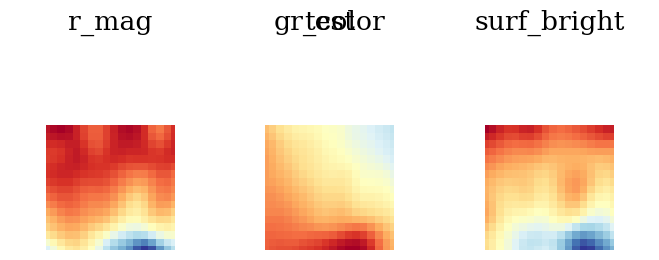

In [18]:
SOM_plot = sompy.mapview.View2DPacked(10, 10, 'test', text_size = 16)
SOM_plot.show(SOM)

In [22]:
predicted_norm_logmstar = SOM.predict(testing_data_norm)

ValueError: operands could not be broadcast together with shapes (84036,3) (2,) 

In [41]:
help(SOM.predict_by)

Help on method predict_by in module sompy.sompy:

predict_by(data, target, k=5, wt='distance') method of sompy.sompy.SOM instance



___

Optuna test

In [1]:
from mpdg_som import SelfOrganizingMap
import optuna

/data2/lsajkov/mpdg/conda/envs/mpdg/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
SOM = SelfOrganizingMap(mapsize = 2,
                        dimension = 2)

In [5]:
SOM.mapsize.copy()

[2, 2]

In [7]:
isinstance(2, int) & (2 != None)

True

In [ ]:
optuna.